In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.svm import LinearSVC, SVC

In [4]:
file = pd.read_csv(r'Dataset/Dataset_13.05.2020_11.18am_1.csv')
tweets = np.asarray(file['Tweet'].copy())
targets = np.asarray(file['Is_Unreliable'].copy())
tweet_embeddings = np.load(r'Dataset/Tweet_Embeddings_Word2Vec_13.05.2020_2.41pm_1.npy', allow_pickle=True)
print(tweet_embeddings.shape)
print(tweet_embeddings[0].shape)
X = list()
for tweet in tweet_embeddings:
    embeddings = np.mean(tweet, axis=0, dtype=np.float64)
    X.append(embeddings)
X = np.asarray(X)
print(X.shape)
print(X.dtype)

y = targets
print(y.shape)
print(y.dtype)

(560,)
(15, 300)
(560, 300)
float64
(560,)
int64


In [189]:
# print(y)
# y[y == 1] = -1
# y[y == 0] = 1
# y[y == -1] = 0
# print(y)

In [5]:
class AE(nn.Module):

    def __init__(self, hidden_size=100):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(300, hidden_size)  # 6*6 from image dimension
        self.fc2 = nn.Linear(hidden_size, 300)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# net = AE()
# print(net)

def train_AE(model, X_train, y_train, X_test, y_test, epochs=100, to_print=False, print_interval=100):
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_mse_list, test_1_mse_list, test_0_mse_list = list(), list(), list()
    # enumerate epochs
    for epoch in tqdm(range(epochs)):
        # clear the gradients
        optimizer.zero_grad()
        X_train = torch.from_numpy(X_train).float()
        X_test = torch.from_numpy(X_test).float()
        output = model(X_train)
#         print(X_train)
#         print(output)
        train_loss = criterion(output, X_train)
        train_loss.backward()
        optimizer.step()
        if to_print and epoch%print_interval == 0:
            print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, train_loss))
        
        train_preds = model(X_train)
        X_train = X_train.numpy()
        train_preds = train_preds.detach().numpy()
        test_preds = model(X_test)
        X_test = X_test.numpy()
        test_preds = test_preds.detach().numpy()
        train_mse = np.mean(np.square(X_train - train_preds), axis=1)
        test_1_mse = np.mean(np.square(X_test[y_test == 1] - test_preds[y_test == 1]), axis=1)
        test_0_mse = np.mean(np.square(X_test[y_test == 0] - test_preds[y_test == 0]), axis=1)
        train_mse_list.append(train_mse), test_1_mse_list.append(test_1_mse), test_0_mse_list.append(test_0_mse)
#         print('Train:', train_mse, ' Test (1_class):', test_1_mse, ' Test (0_class):', test_0_mse)
        
    return model, (train_mse_list, test_1_mse_list, test_0_mse_list)

def predict_AE(model, X_train, X_test, threshold, above_thres_class=0):
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    train_out = model(X_train)
    X_train = X_train.numpy()
    train_out = train_out.detach().numpy()
    test_out = model(X_test)
    X_test = X_test.numpy()
    test_out = test_out.detach().numpy()
    train_mse = np.mean(np.square(X_train - train_out), axis=1)
    test_mse = np.mean(np.square(X_test - test_out), axis=1)
    
    train_preds, test_preds = np.empty((train_mse.shape[0])), np.empty((test_mse.shape[0]))
    train_preds[train_mse > threshold] = above_thres_class
    train_preds[train_mse <= threshold] = (above_thres_class+1)%2
    test_preds[test_mse > threshold] = above_thres_class
    test_preds[test_mse <= threshold] = (above_thres_class+1)%2
        
    return (train_preds, test_preds)

In [110]:
# from scipy import stats

# stats.describe(X)

In [154]:
# model = AE()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer.zero_grad()
# X_trial = X.copy()
# X_trial = torch.from_numpy(X_trial).float()
# output = model(X_trial)
# output = output.detach().numpy()

# stats.describe(output)

In [161]:
# np.square(X_trial[0] - output[0])
# output[0]
# X_trial[0]

In [20]:
# Autoencoder on class=1 as training data

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

for percent in np.arange(0.9, 0.01, -0.1):
    
    b_a_score, b_f_score, b_p_score, b_r_score, b_roc_score = list(), list(), list(), list(), list()
    b_t_a_score, b_t_f_score, b_t_p_score, b_t_r_score, b_t_roc_score = list(), list(), list(), list(), list()
    
    a_score, f_score, p_score, r_score, roc_score = list(), list(), list(), list(), list()
    t_a_score, t_f_score, t_p_score, t_r_score, t_roc_score = list(), list(), list(), list(), list()
    
    X_0, X_1_, y_0, y_1_ = X[y==0].copy(), X[y==1].copy(), y[y==0].copy(), y[y==1].copy()
    X_1, _, y_1, _ = train_test_split(X_1_, y_1_, train_size=percent, shuffle=True, random_state=0)
    
    for (train_1_index, test_1_index), (train_0_index, test_0_index) in zip(kfold.split(X_1, y_1), kfold.split(X_0, y_0)):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # For Binary Classifier (SVC)
        b_X_train, b_y_train = np.concatenate((X_1[train_1_index].copy(), X_0[train_0_index].copy())), np.concatenate((y_1[train_1_index].copy(), y_0[train_0_index].copy()))
        b_X_train, b_y_train = shuffle(b_X_train, b_y_train, random_state=0)
        # For Autoencoder
#         X_train, y_train = X_0[train_0_index].copy(), y_0[train_0_index].copy()
        X_train, y_train = X_1[train_1_index].copy(), y_1[train_1_index].copy()
        X_test, y_test = np.concatenate((X_1[test_1_index].copy(), X_0[test_0_index].copy())), np.concatenate((y_1[test_1_index].copy(), y_0[test_0_index].copy()))
        X_test, y_test = shuffle(X_test, y_test, random_state=0)
#         print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print(y_train.shape, sum(y_train))
#         print(y_test.shape, sum(y_test))
#         b_y_train[b_y_train == 1] = -1
#         b_y_train[b_y_train == 0] = 1
#         b_y_train[b_y_train == -1] = 0
#         y_train[y_train == 1] = -1
#         y_train[y_train == 0] = 1
#         y_train[y_train == -1] = 0
#         y_test[y_test == 1] = -1
#         y_test[y_test == 0] = 1
#         y_test[y_test == -1] = 0
#         print(y_train.shape, sum(y_train))
#         print(y_test.shape, sum(y_test))

        binary_clf = SVC()
        binary_clf.fit(b_X_train, b_y_train)
        b_train_preds = binary_clf.predict(b_X_train)
        b_test_preds = binary_clf.predict(X_test)
        b_t_a_score.append(accuracy_score(b_y_train, b_train_preds))
        b_t_f_score.append(f1_score(b_y_train, b_train_preds)), b_t_p_score.append(precision_score(b_y_train, b_train_preds)), b_t_r_score.append(recall_score(b_y_train, b_train_preds))
        b_a_score.append(accuracy_score(y_test, b_test_preds))
        b_f_score.append(f1_score(y_test, b_test_preds)), b_p_score.append(precision_score(y_test, b_test_preds)), b_r_score.append(recall_score(y_test, b_test_preds))
#         print('BC Train: ', b_t_a_score[-1], b_t_f_score[-1], b_t_p_score[-1], b_t_r_score[-1])
#         print('BC Test : ', b_a_score[-1], b_f_score[-1], b_p_score[-1], b_r_score[-1])

        model = AE(hidden_size=100).to(device)
    #     print(model)
        n_epochs = 100
        model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, to_print=False, epochs=n_epochs, print_interval=n_epochs/10)

#         var_for_plot = -(n_epochs-10)
#         # train_mse_list, test_1_mse_list, test_0_mse_list = np.mean(np.asarray(train_mse_list), axis=1), np.mean(np.asarray(test_1_mse_list), axis=1), np.mean(np.asarray(test_0_mse_list), axis=1)
#         plt.plot(np.arange(len(train_mse_list))[var_for_plot:], np.mean(np.asarray(train_mse_list), axis=1)[var_for_plot:], label='train_mse_list', color='blue')
#         plt.plot(np.arange(len(test_1_mse_list))[var_for_plot:], np.mean(np.asarray(test_1_mse_list), axis=1)[var_for_plot:], label='test_1_mse_list', color='red')
#         plt.plot(np.arange(len(test_0_mse_list))[var_for_plot:], np.mean(np.asarray(test_0_mse_list), axis=1)[var_for_plot:], label='test_0_mse_list', color='yellow')
#         plt.show()

        best_f = 0
        train_preds, preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
        for th in np.arange(0.0001, 0.0100, 0.0001):
            (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
            if (f1_score(y_test, te_preds) > best_f):
                best_f = f1_score(y_test, te_preds)
                train_preds = tr_preds
                preds = te_preds

    #     best_f = 0
    #     train_preds, preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
    #     for h_size in np.arange(1, 300, 5):
    #         for ep in np.arange(1, 200, 5):
    #             model = AE(hidden_size=h_size).to(device)
    #             # print(model)
    #             n_epochs = ep
    #             model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, to_print=False, epochs=n_epochs, print_interval=n_epochs/10)

    #             var_for_plot = -(n_epochs-10)
    #             # train_mse_list, test_1_mse_list, test_0_mse_list = np.mean(np.asarray(train_mse_list), axis=1), np.mean(np.asarray(test_1_mse_list), axis=1), np.mean(np.asarray(test_0_mse_list), axis=1)
    #             # plt.plot(np.arange(len(train_mse_list))[var_for_plot:], np.mean(np.asarray(train_mse_list), axis=1)[var_for_plot:], label='train_mse_list', color='blue')
    #             # plt.plot(np.arange(len(test_1_mse_list))[var_for_plot:], np.mean(np.asarray(test_1_mse_list), axis=1)[var_for_plot:], label='test_1_mse_list', color='red')
    #             # plt.plot(np.arange(len(test_0_mse_list))[var_for_plot:], np.mean(np.asarray(test_0_mse_list), axis=1)[var_for_plot:], label='test_0_mse_list', color='yellow')
    #             # plt.show()

    #             for th in np.arange(0.0001, 0.0100, 0.0001):
    #                 (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
    #                 if (f1_score(y_test, te_preds) > best_f):
    #                     best_f = f1_score(y_test, te_preds)
    #                     train_preds = tr_preds
    #                     preds = te_preds

        t_a_score.append(accuracy_score(y_train, train_preds))
        t_f_score.append(f1_score(y_train, train_preds)), t_p_score.append(precision_score(y_train, train_preds)), t_r_score.append(recall_score(y_train, train_preds))
        a_score.append(accuracy_score(y_test, preds))
        f_score.append(f1_score(y_test, preds)), p_score.append(precision_score(y_test, preds)), r_score.append(recall_score(y_test, preds))
#         print('AE Train: ', t_a_score[-1], t_f_score[-1], t_p_score[-1], t_r_score[-1])
#         print('AE Test : ', a_score[-1], f_score[-1], p_score[-1], r_score[-1])

    print('')
    print('percentage of class=1 (actual) samples:', percent)
    print('BC Train: ', sum(b_t_a_score)/len(b_t_a_score), sum(b_t_f_score)/len(b_t_f_score), sum(b_t_p_score)/len(b_t_p_score), sum(b_t_r_score)/len(b_t_r_score))
    print('BC Test : ', sum(b_a_score)/len(b_a_score), sum(b_f_score)/len(b_f_score), sum(b_p_score)/len(b_p_score), sum(b_r_score)/len(b_r_score))
    print('AE Train: ', sum(t_a_score)/len(t_a_score), sum(t_f_score)/len(t_f_score), sum(t_p_score)/len(t_p_score), sum(t_r_score)/len(t_r_score))
    print('AE Test : ', sum(a_score)/len(a_score), sum(f_score)/len(f_score), sum(p_score)/len(p_score), sum(r_score)/len(r_score))

  0%|          | 0/100 [00:00<?, ?it/s]


percentage of class=1 (actual) samples: 0.9
BC Train:  0.9388955200127317 0.9366152828957306 0.9213762730525735 0.9523809523809524
BC Test :  0.8158128610423411 0.8045220284047296 0.8084073149304111 0.8015873015873015
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.6465011955394739 0.7004719764011801 0.5887971507204144 0.8690476190476191


 26%|██▌       | 26/100 [00:00<00:00, 257.67it/s]


percentage of class=1 (actual) samples: 0.8
BC Train:  0.9424570221522036 0.9355539280496689 0.9316262273554781 0.9397166293810589
BC Test :  0.8135114667818492 0.7815956638300433 0.8137113431231078 0.7547747747747747
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.6566081699660695 0.6678682342502218 0.5951048951048952 0.7814414414414413


 27%|██▋       | 27/100 [00:00<00:00, 263.59it/s]


percentage of class=1 (actual) samples: 0.7000000000000001
BC Train:  0.9443183929092696 0.9320159207012656 0.935837915399185 0.9285770209434331
BC Test :  0.8235759493670886 0.7793636028054634 0.8055555555555557 0.7552447552447553
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.6047732067510548 0.646233896540645 0.5151430375657179 0.8726495726495727


 26%|██▌       | 26/100 [00:00<00:00, 257.82it/s]


percentage of class=1 (actual) samples: 0.6000000000000001
BC Train:  0.9419504238587986 0.9205612900551342 0.9436870661225639 0.8988095238095237
BC Test :  0.8348545861297539 0.7588684706203802 0.8385588613884498 0.6964285714285715
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.6494407158836689 0.6220973639155458 0.545516970975023 0.7619047619047619


 31%|███       | 31/100 [00:00<00:00, 302.62it/s]


percentage of class=1 (actual) samples: 0.5000000000000001
BC Train:  0.9380692416509201 0.9019896677907727 0.9521652632396703 0.8570121253717685
BC Test :  0.8261503866815362 0.7068949433039942 0.8083542188805347 0.6285846438482886
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.6526754280466204 0.5568369070825211 0.49424528113052696 0.6497070613629355


 31%|███       | 31/100 [00:00<00:00, 307.16it/s]


percentage of class=1 (actual) samples: 0.40000000000000013
BC Train:  0.9349579174006655 0.8728345798956486 0.9724810213940649 0.7945945945945946
BC Test :  0.8394327894327894 0.656487372276846 0.8383940620782727 0.5457562825983878
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.6448717948717949 0.5298706584190386 0.473169191919192 0.6711711711711712


100%|██████████| 100/100 [00:00<00:00, 310.47it/s]
/home/saswat/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 34%|███▍      | 34/100 [00:00<00:00, 335.81it/s]


percentage of class=1 (actual) samples: 0.30000000000000016
BC Train:  0.917576437778458 0.7839783186385795 0.990990990990991 0.6488095238095238
BC Test :  0.8104592873594364 0.37175195281364576 0.7841880341880342 0.25
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.7031115928284334 0.47926310817194145 0.4137903861308117 0.5833333333333334


100%|██████████| 100/100 [00:00<00:00, 292.76it/s]
/home/saswat/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 100/100 [00:00<00:00, 348.09it/s]
/home/saswat/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 49%|████▉     | 49/100 [00:00<00:00, 474.26it/s]


percentage of class=1 (actual) samples: 0.20000000000000018
BC Train:  0.8720155349135169 0.3731179023682274 1.0 0.2316263632053106
BC Test :  0.8303481262552058 0.0 0.0 0.0
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.7618656108700357 0.4022918773171554 0.345679012345679 0.48245614035087714


100%|██████████| 100/100 [00:00<00:00, 448.93it/s]
/home/saswat/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 100/100 [00:00<00:00, 365.31it/s]
/home/saswat/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 100/100 [00:00<00:00, 367.13it/s]



percentage of class=1 (actual) samples: 0.1000000000000002
BC Train:  0.9204740148486579 0.21118012422360247 0.6666666666666666 0.12573099415204678
BC Test :  0.9091251885369532 0.0 0.0 0.0
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.8471593765711413 0.3208699902248289 0.29473304473304474 0.38888888888888884


In [13]:
# Autoencoder on class=0 as training data (class=0 has been changed to class=1 for calculating f1_score, precision, etc.)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

for percent in np.arange(0.9, 0.01, -0.1):
    
    b_a_score, b_f_score, b_p_score, b_r_score, b_roc_score = list(), list(), list(), list(), list()
    b_t_a_score, b_t_f_score, b_t_p_score, b_t_r_score, b_t_roc_score = list(), list(), list(), list(), list()
    
    a_score, f_score, p_score, r_score, roc_score = list(), list(), list(), list(), list()
    t_a_score, t_f_score, t_p_score, t_r_score, t_roc_score = list(), list(), list(), list(), list()
    
    X_0, X_1_, y_0, y_1_ = X[y==0].copy(), X[y==1].copy(), y[y==0].copy(), y[y==1].copy()
    X_1, _, y_1, _ = train_test_split(X_1_, y_1_, train_size=percent, shuffle=True, random_state=0)
    
    for (train_1_index, test_1_index), (train_0_index, test_0_index) in zip(kfold.split(X_1, y_1), kfold.split(X_0, y_0)):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # For Binary Classifier (SVC)
        b_X_train, b_y_train = np.concatenate((X_1[train_1_index].copy(), X_0[train_0_index].copy())), np.concatenate((y_1[train_1_index].copy(), y_0[train_0_index].copy()))
        b_X_train, b_y_train = shuffle(b_X_train, b_y_train, random_state=0)
        # For Autoencoder
        X_train, y_train = X_0[train_0_index].copy(), y_0[train_0_index].copy()
        X_test, y_test = np.concatenate((X_1[test_1_index].copy(), X_0[test_0_index].copy())), np.concatenate((y_1[test_1_index].copy(), y_0[test_0_index].copy()))
        X_test, y_test = shuffle(X_test, y_test, random_state=0)
#         print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print(y_train.shape, sum(y_train))
#         print(y_test.shape, sum(y_test))
        b_y_train[b_y_train == 1] = -1
        b_y_train[b_y_train == 0] = 1
        b_y_train[b_y_train == -1] = 0
        y_train[y_train == 1] = -1
        y_train[y_train == 0] = 1
        y_train[y_train == -1] = 0
        y_test[y_test == 1] = -1
        y_test[y_test == 0] = 1
        y_test[y_test == -1] = 0
#         print(y_train.shape, sum(y_train))
#         print(y_test.shape, sum(y_test))

        binary_clf = SVC()
        binary_clf.fit(b_X_train, b_y_train)
        b_train_preds = binary_clf.predict(b_X_train)
        b_test_preds = binary_clf.predict(X_test)
        b_t_a_score.append(accuracy_score(b_y_train, b_train_preds))
        b_t_f_score.append(f1_score(b_y_train, b_train_preds)), b_t_p_score.append(precision_score(b_y_train, b_train_preds)), b_t_r_score.append(recall_score(b_y_train, b_train_preds))
        b_a_score.append(accuracy_score(y_test, b_test_preds))
        b_f_score.append(f1_score(y_test, b_test_preds)), b_p_score.append(precision_score(y_test, b_test_preds)), b_r_score.append(recall_score(y_test, b_test_preds))
#         print('BC Train: ', b_t_a_score[-1], b_t_f_score[-1], b_t_p_score[-1], b_t_r_score[-1])
#         print('BC Test : ', b_a_score[-1], b_f_score[-1], b_p_score[-1], b_r_score[-1])

        model = AE(hidden_size=100).to(device)
    #     print(model)
        n_epochs = 100
        model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, to_print=False, epochs=n_epochs, print_interval=n_epochs/10)

#         var_for_plot = -(n_epochs-10)
#         # train_mse_list, test_1_mse_list, test_0_mse_list = np.mean(np.asarray(train_mse_list), axis=1), np.mean(np.asarray(test_1_mse_list), axis=1), np.mean(np.asarray(test_0_mse_list), axis=1)
#         plt.plot(np.arange(len(train_mse_list))[var_for_plot:], np.mean(np.asarray(train_mse_list), axis=1)[var_for_plot:], label='train_mse_list', color='blue')
#         plt.plot(np.arange(len(test_1_mse_list))[var_for_plot:], np.mean(np.asarray(test_1_mse_list), axis=1)[var_for_plot:], label='test_1_mse_list', color='red')
#         plt.plot(np.arange(len(test_0_mse_list))[var_for_plot:], np.mean(np.asarray(test_0_mse_list), axis=1)[var_for_plot:], label='test_0_mse_list', color='yellow')
#         plt.show()

        best_f = 0
        train_preds, preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
        for th in np.arange(0.0001, 0.0100, 0.0001):
            (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
            if (f1_score(y_test, te_preds) > best_f):
                best_f = f1_score(y_test, te_preds)
                train_preds = tr_preds
                preds = te_preds

    #     best_f = 0
    #     train_preds, preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
    #     for h_size in np.arange(1, 300, 5):
    #         for ep in np.arange(1, 200, 5):
    #             model = AE(hidden_size=h_size).to(device)
    #             # print(model)
    #             n_epochs = ep
    #             model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, to_print=False, epochs=n_epochs, print_interval=n_epochs/10)

    #             var_for_plot = -(n_epochs-10)
    #             # train_mse_list, test_1_mse_list, test_0_mse_list = np.mean(np.asarray(train_mse_list), axis=1), np.mean(np.asarray(test_1_mse_list), axis=1), np.mean(np.asarray(test_0_mse_list), axis=1)
    #             # plt.plot(np.arange(len(train_mse_list))[var_for_plot:], np.mean(np.asarray(train_mse_list), axis=1)[var_for_plot:], label='train_mse_list', color='blue')
    #             # plt.plot(np.arange(len(test_1_mse_list))[var_for_plot:], np.mean(np.asarray(test_1_mse_list), axis=1)[var_for_plot:], label='test_1_mse_list', color='red')
    #             # plt.plot(np.arange(len(test_0_mse_list))[var_for_plot:], np.mean(np.asarray(test_0_mse_list), axis=1)[var_for_plot:], label='test_0_mse_list', color='yellow')
    #             # plt.show()

    #             for th in np.arange(0.0001, 0.0100, 0.0001):
    #                 (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
    #                 if (f1_score(y_test, te_preds) > best_f):
    #                     best_f = f1_score(y_test, te_preds)
    #                     train_preds = tr_preds
    #                     preds = te_preds

        t_a_score.append(accuracy_score(y_train, train_preds))
        t_f_score.append(f1_score(y_train, train_preds)), t_p_score.append(precision_score(y_train, train_preds)), t_r_score.append(recall_score(y_train, train_preds))
        a_score.append(accuracy_score(y_test, preds))
        f_score.append(f1_score(y_test, preds)), p_score.append(precision_score(y_test, preds)), r_score.append(recall_score(y_test, preds))
#         print('AE Train: ', t_a_score[-1], t_f_score[-1], t_p_score[-1], t_r_score[-1])
#         print('AE Test : ', a_score[-1], f_score[-1], p_score[-1], r_score[-1])

    print('')
    print('percentage of class=1 (actual) samples:', percent)
    print('BC Train: ', sum(b_t_a_score)/len(b_t_a_score), sum(b_t_f_score)/len(b_t_f_score), sum(b_t_p_score)/len(b_t_p_score), sum(b_t_r_score)/len(b_t_r_score))
    print('BC Test : ', sum(b_a_score)/len(b_a_score), sum(b_f_score)/len(b_f_score), sum(b_p_score)/len(b_p_score), sum(b_r_score)/len(b_r_score))
    print('AE Train: ', sum(t_a_score)/len(t_a_score), sum(t_f_score)/len(t_f_score), sum(t_p_score)/len(t_p_score), sum(t_r_score)/len(t_r_score))
    print('AE Test : ', sum(a_score)/len(a_score), sum(f_score)/len(f_score), sum(p_score)/len(p_score), sum(r_score)/len(r_score))

 19%|█▉        | 19/100 [00:00<00:00, 183.69it/s]


percentage of class=1 (actual) samples: 0.9
BC Train:  0.9388955200127317 0.9410154558166587 0.955737000429738 0.9267533015161099
BC Test :  0.8158128610423411 0.8256873852793158 0.8236098094345516 0.8285670708457257
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.5338242451173322 0.6907524666231133 0.5306563124984177 0.989247311827957


 21%|██        | 21/100 [00:00<00:00, 208.16it/s]


percentage of class=1 (actual) samples: 0.8
BC Train:  0.9424570221522036 0.9480137859745227 0.951556986110762 0.9446265309642919
BC Test :  0.8135114667818492 0.8369461746510928 0.8161297082089162 0.8606726149622513
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.5615212938451077 0.7148391318013245 0.5596526894326789 0.989247311827957


 20%|██        | 20/100 [00:00<00:00, 196.81it/s]


percentage of class=1 (actual) samples: 0.7000000000000001
BC Train:  0.9443183929092696 0.9528403581483634 0.9505204686551837 0.9553408851321565
BC Test :  0.8235759493670886 0.8529808641759722 0.8354986249819075 0.8714253031342943
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.590321729957806 0.7389304566894962 0.5910209948590243 0.985663082437276


 20%|██        | 20/100 [00:00<00:00, 199.67it/s]


percentage of class=1 (actual) samples: 0.6000000000000001
BC Train:  0.9419504238587986 0.9542600278413474 0.941126678960793 0.9678569374964061
BC Test :  0.8348545861297539 0.8741583478857698 0.8353887701275694 0.9177915046137421
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.6316629381058911 0.7704851788571583 0.6309641097818438 0.989247311827957


 19%|█▉        | 19/100 [00:00<00:00, 188.54it/s]


percentage of class=1 (actual) samples: 0.5000000000000001
BC Train:  0.9380692416509201 0.9547291922223821 0.9320564480960106 0.9785712916642707
BC Test :  0.8261503866815362 0.8764093708025887 0.8328034363668587 0.9249599633951041
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.6761966718418577 0.8034866497018497 0.674918411135753 0.992831541218638


 14%|█▍        | 14/100 [00:00<00:00, 139.74it/s]


percentage of class=1 (actual) samples: 0.40000000000000013
BC Train:  0.9349579174006655 0.9562779551906971 0.9241817285003312 0.9910873440285205
BC Test :  0.8394327894327894 0.895045401070561 0.8411489964717451 0.9571036376115306
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.7193861693861695 0.8348328861218152 0.7203139557643374 0.992831541218638


 14%|█▍        | 14/100 [00:00<00:00, 139.41it/s]


percentage of class=1 (actual) samples: 0.30000000000000016
BC Train:  0.917576437778458 0.9490704678818092 0.9045528226493746 0.9982174688057041
BC Test :  0.8104592873594364 0.8882510524301569 0.8134502923976609 0.9785708838557157
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.7692272953077722 0.8683205217796414 0.7737929415846484 0.989247311827957


 17%|█▋        | 17/100 [00:00<00:00, 164.62it/s]


percentage of class=1 (actual) samples: 0.20000000000000018
BC Train:  0.8720155349135169 0.9287083731001714 0.8669296064477408 1.0
BC Test :  0.8303481262552058 0.9073111914813015 0.8328597287668084 0.996415770609319
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.8302949757595776 0.9069761771346445 0.8348350808213194 0.992831541218638


100%|██████████| 100/100 [00:00<00:00, 253.51it/s]



percentage of class=1 (actual) samples: 0.1000000000000002
BC Train:  0.9204740148486579 0.9581112809289406 0.9196275662923488 1.0
BC Test :  0.9091251885369532 0.9523957523957525 0.9091251885369532 1.0
AE Train:  1.0 1.0 1.0 1.0
AE Test :  0.902589240824535 0.9486217414696796 0.9113097207156614 0.989247311827957


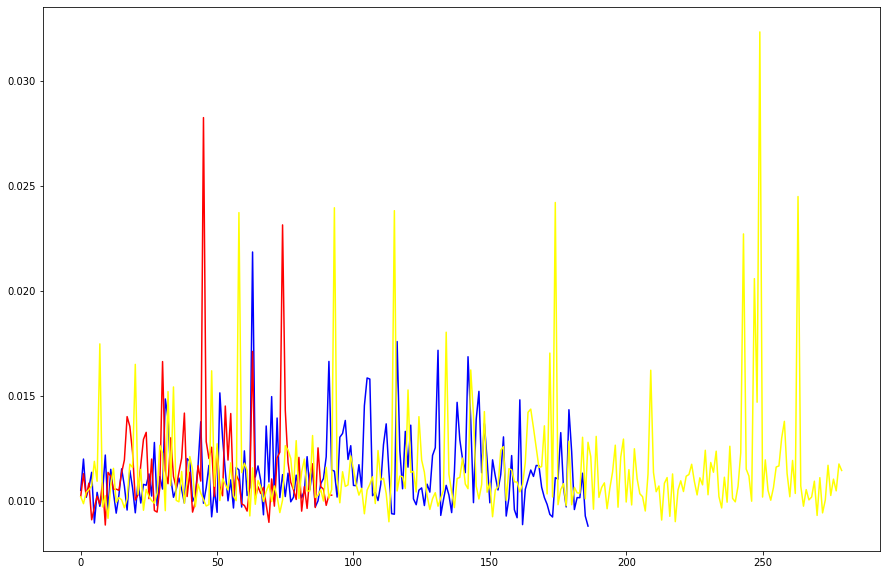

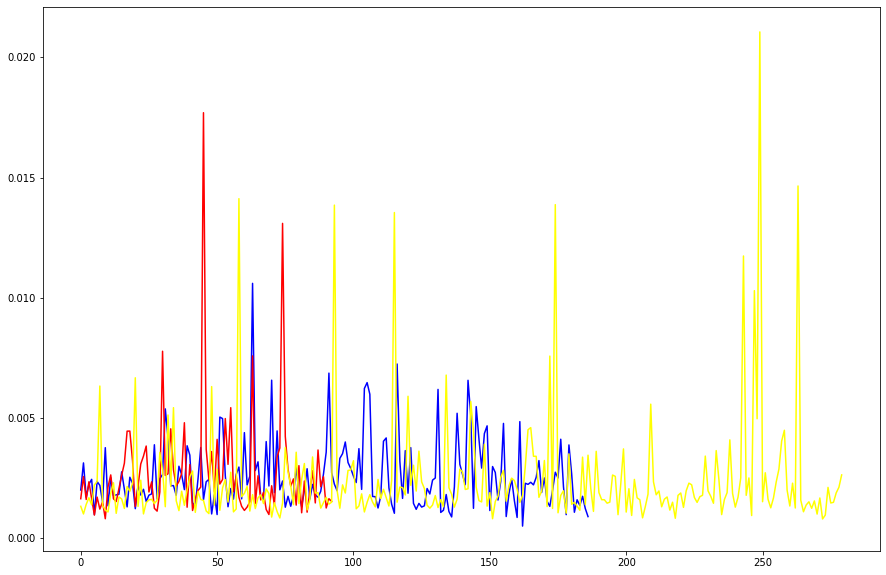

In [241]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(train_mse_list[-1].shape[0]), train_mse_list[10], label='train_mse_list', color='blue')
# plt.show()
plt.plot(np.arange(test_1_mse_list[-1].shape[0]), test_1_mse_list[10], label='test_1_mse_list', color='red')
# plt.show()
plt.plot(np.arange(test_0_mse_list[-1].shape[0]), test_0_mse_list[10], label='test_0_mse_list', color='yellow')
plt.show()

plt.figure(figsize=(15, 10))
plt.plot(np.arange(train_mse_list[-1].shape[0]), train_mse_list[-1], label='train_mse_list', color='blue')
# plt.show()
plt.plot(np.arange(test_1_mse_list[-1].shape[0]), test_1_mse_list[-1], label='test_1_mse_list', color='red')
# plt.show()
plt.plot(np.arange(test_0_mse_list[-1].shape[0]), test_0_mse_list[-1], label='test_0_mse_list', color='yellow')
plt.show()

In [198]:
# np.asarray(train_mse_list[-2])

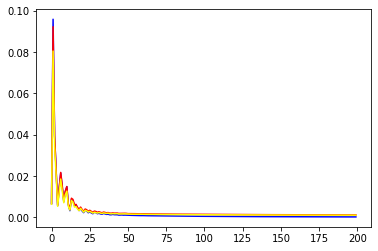

In [200]:
plt.plot(np.arange(len(train_mse_list))[:], np.mean(np.asarray(train_mse_list), axis=1)[:], label='train_mse_list', color='blue')
plt.plot(np.arange(len(test_1_mse_list))[:], np.mean(np.asarray(test_1_mse_list), axis=1)[:], label='test_1_mse_list', color='red')
plt.plot(np.arange(len(test_0_mse_list))[:], np.mean(np.asarray(test_0_mse_list), axis=1)[:], label='test_0_mse_list', color='yellow')
plt.show()

In [169]:
# y_trial = y.copy()
# y_trial[y_trial == 1] = -1
# y_trial[y_trial == 0] = 1
# y_trial[y_trial == -1] = 0
# print(y_trial)

In [19]:
A = np.array([[1, 2], [3, 4], [5, 6]])
B = np.array(([1, 2, 3]))
print(A)
print(B)
# np.random.shuffle(A)
# np.random.shuffle(B)
np.random.shuffle()
print(A)
print(B)

[[1 2]
 [3 4]
 [5 6]]
[1 2 3]


TypeError: object of type 'zip' has no len()